<a href="https://colab.research.google.com/github/DuncanJWood/BiX/blob/main/exercise4_foraging_and_rl_and_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4: Foraging and reinforcement learning**

## Getting started

This homework will involve concepts from the labs we've gone over in class. Feel free to reference them as you complete the assignment.

This homework contains 2 sections:
1. Investigation of patchy environment random initialization effects on foraging agents with different strategies.
1. Investigation of various actor-critic agents in a new type of dynamic bandit task - one where one arm becomes *more* rewarding partway through each experiment.

Fill out the code cells below and answer the questions to complete the assignment. Most of the programming is quite straightforward, as it is all based on code from the labs, which you can use/modify in this notebook.

---
## Section 1 - Foraging [30 pt]

In Lab 7, you investigated how random search, chemotaxis, and infotaxis agents behaved in a "patchy" foraging environment. We didn't get to testing out the effects of random initializations in class. In this section of the homework you will carry out that analysis.

Following the environment patches as bushes metaphor, different random seeds determine where the random bushes grow.

### Question 1.1 [4 pt]
Why is it important to check multiple random seeds when comparing foraging strategies in patchy environments?

In [ ]:
# Write your answer here, as a Python comment. Explain yourself.
# For the same reason it is important to have large sample sizes,
# if we want to argue that are results show something general than they cannot be the result of specifc factors such as the random seed.
# In other words, we should be sure that our results are robust to the random number generation processes.


### In the code cells below, run and fill in code as needed according to the text instructions before each one. Feel free to refer to lab 7 for help.

Change the directory to where we want to clone in the specific explorationlib code library branch.

In [4]:
cd /content

/content


Clone in the `target-patch-dev` explorationlib branch (the branch that has our new patchy environment functions).

In [5]:
!git clone -b target-patch-dev https://github.com/coaxlab/explorationlib

Cloning into 'explorationlib'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 769 (delta 266), reused 241 (delta 241), pack-reused 496
Receiving objects: 100% (769/769), 16.62 MiB | 11.37 MiB/s, done.
Resolving deltas: 100% (467/467), done.


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [6]:
cd /content/explorationlib

/content/explorationlib


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [7]:
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-g9osc0_f
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-g9osc0_f
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Preparing metadata (setup.py) ... done
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14215 sha256=db59e661957ab24bb06474cb0de753f7205f227c9c14c9d8be3948933aaef3b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-s9_1zn77/wheels/b0/53/2e/e282706624110bc964538d7840bef68fef2bc1865a87e3016e
Successfully built gym-maze


Import specific modules from the libraries we loaded. We'll use these modules to create and plot enviornments, run experiments with different exploration agents in these environments, visualize their behaviors, and evaluate their performance according to various metrics.

In [10]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

/content/explorationlib/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Create a new patchy environment [2 pt]

In the code block below, set up a new patch environment like our foraging lab in the following way:
- Have there be 4 patches of 15 targets each.
- Have each patch have radius 3.
- Set the random seed to 1257.

In [ ]:
# Your code here
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared agent parameters
num_experiments = 50
num_steps = 400
seed_value = 5257

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 4 #         # number of patches
n_per_patch = 15 #      # number targets per patch
radius = 3 #            # radius of each patch
target_boundary = (10, 10)

# Generate patches of targets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Visualize the patchy environment [2 pt]
In the code cell below, make a plot of the patchy environment you just made.

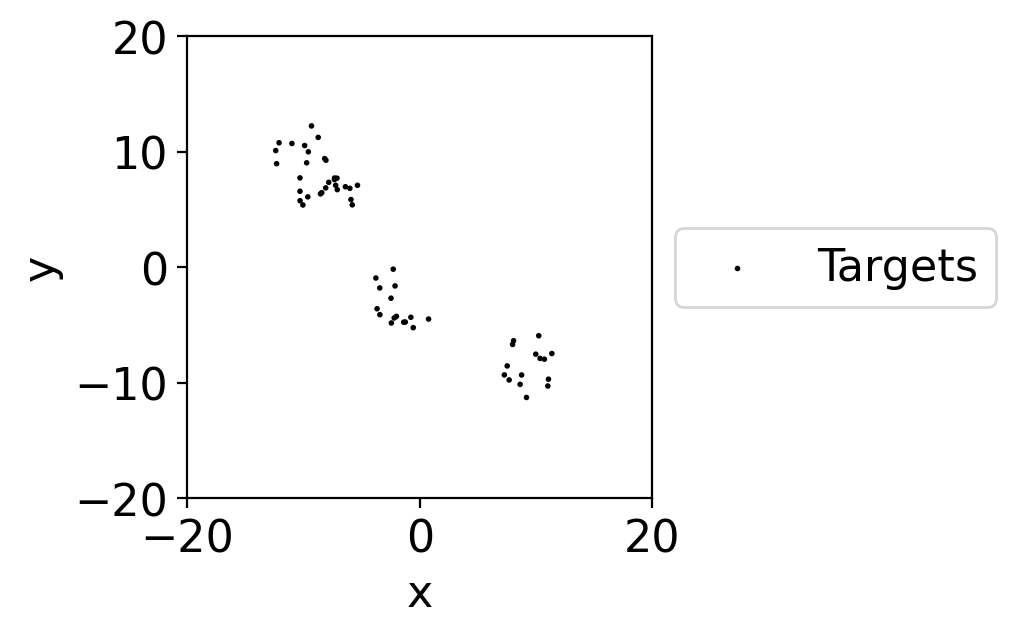

In [ ]:
# Your code here
plot_boundary = (20, 20)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Create the agents [2 pt]
In the code cell below, create a random search, chemotaxis, and infotaxis agent like we did in Lab 7.

In [ ]:
# Your code here
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

drift_rate = 1
threshold = 3

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)


# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)

info.seed(seed_value)

[5257]

### Run the experiments [2 pt]
In the code cell below, run 50 experiments of 400 steps each for each of the agents. Note - you may have set the number of experiments and steps earlier during your environment setup code.

In [ ]:
# Your code here
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

### Visualize proportion of time spent on patches [2 pt]
In the code cell below:
- Plot bar plots with error bars for the proportion of time spent on patches for each agent.
- Plot a histogram for the proportion of time spent on patches for each agent.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

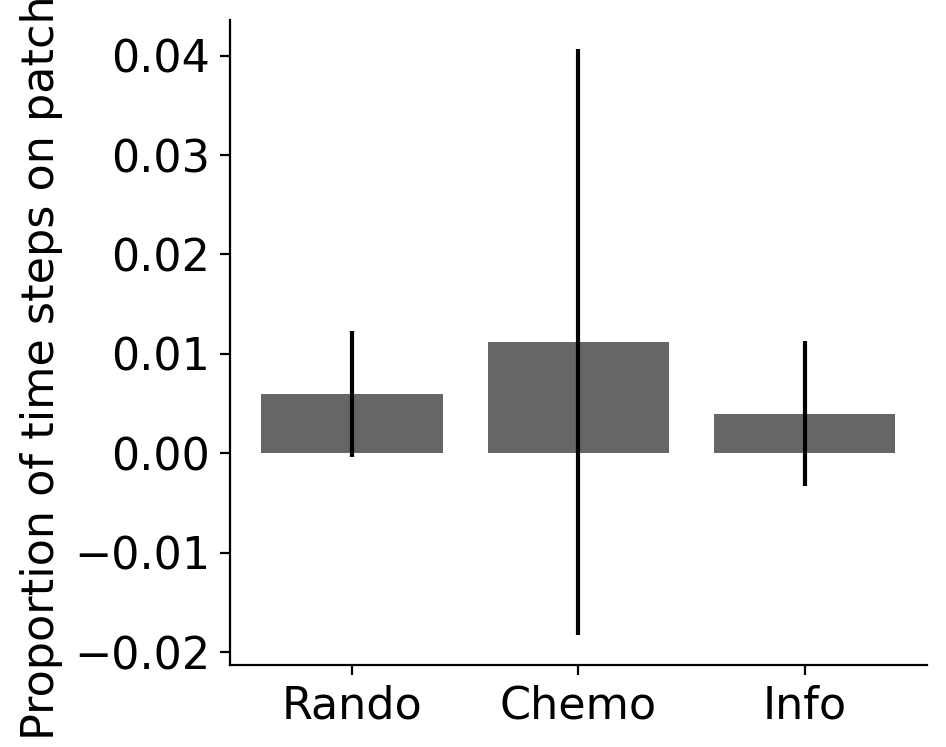

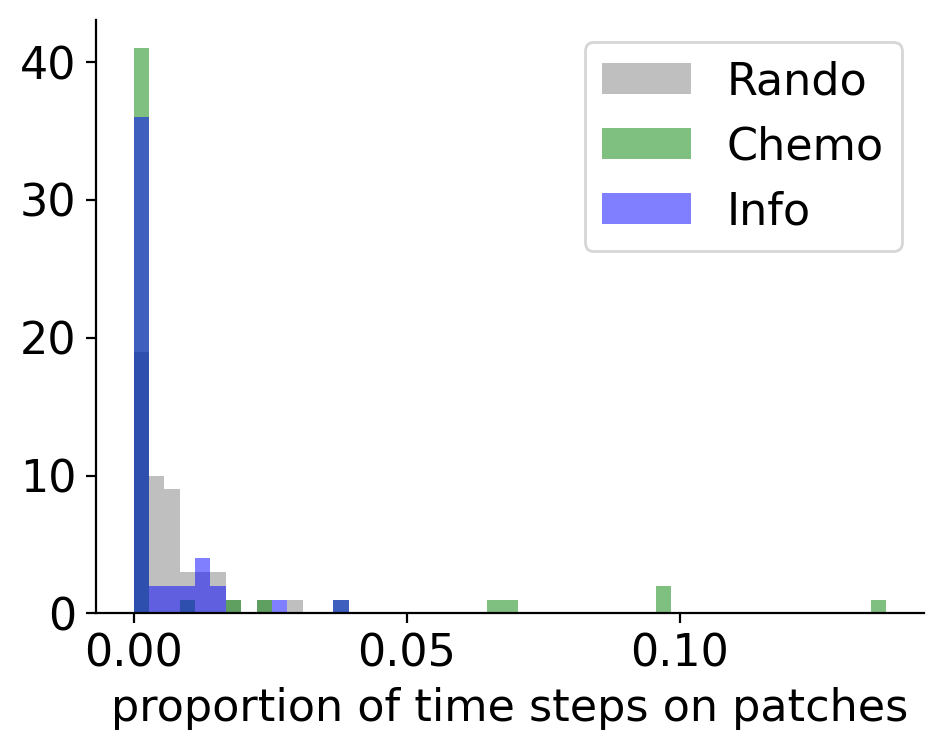

In [ ]:
# Your code here
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", 'Info']
colors = ["gray", "green", 'blue']

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

### Visualize total reward [2 pt]
In the code cell below:
- Plot bar plots with error bars for the total reward for each agent.
- Plot a histogram of total reward for each agent.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

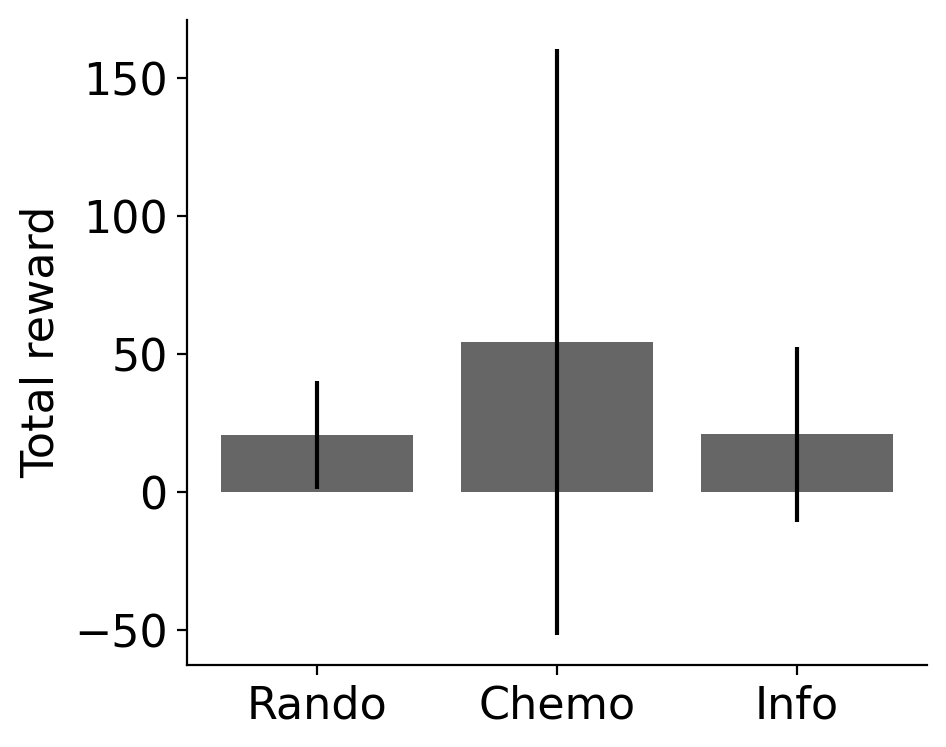

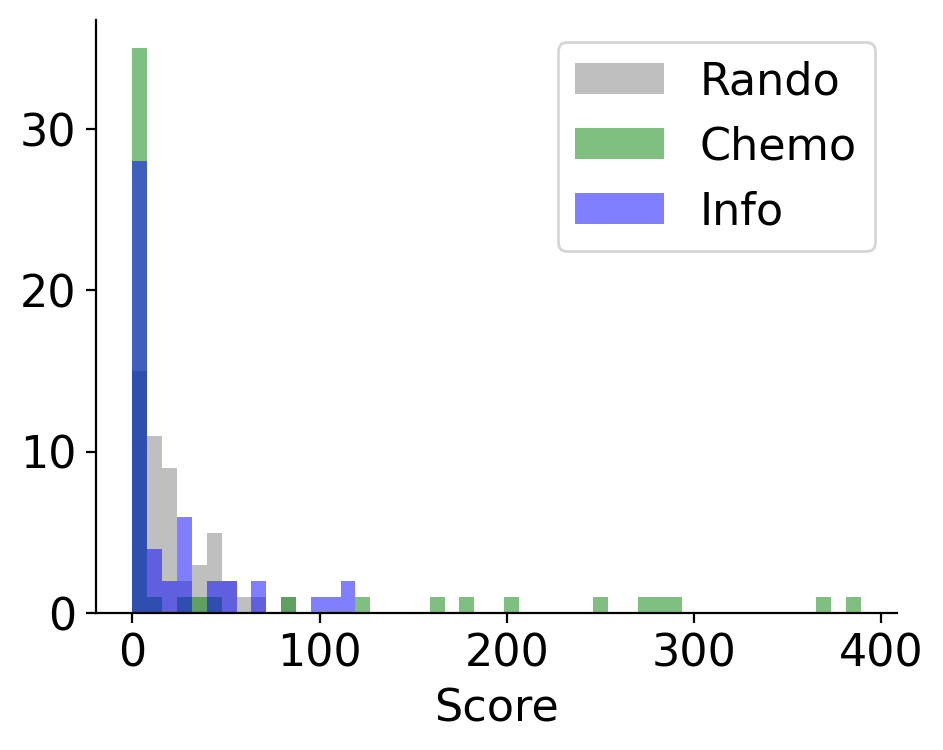

In [ ]:
# Your code here
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", 'Info']
colors = ["gray", "green", 'blue']

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Visualize agent deaths [2 pt]
In the code cell below, plot a bar plot of the number of deaths for each agent type.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

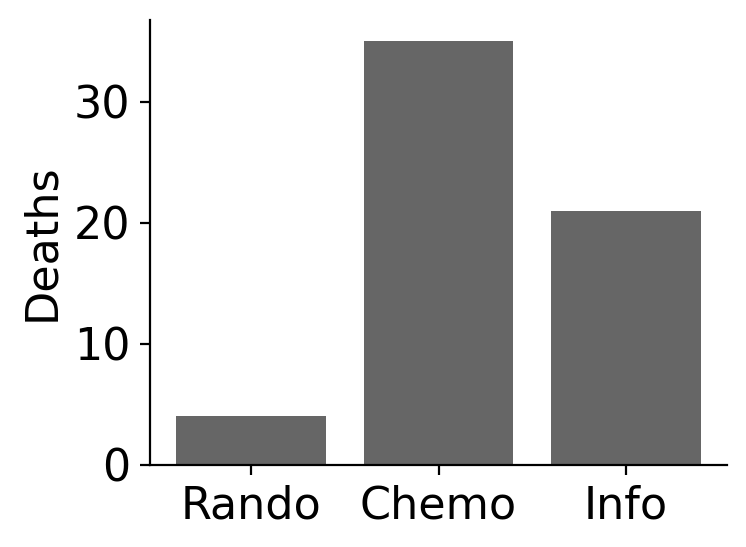

In [ ]:
# Your code here
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", 'Info']

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Question 1.2 [4 pt]
Describe the performance of each agent type according to each of the metrics (on-patch proportion, total reward, deaths). Why do you think this pattern of performance occured?

In [ ]:
# Write your answer here, as a Python comment. Explain yourself.
# The Rando agent is just being random and the Chemo and Info agents are critically failing in almost all trials.

# The Chemo agent is getting caught between patches,
#   thus in the vast majority of trials it has a score of zero (dies)
#   and spends no time on a patch.
# However, if it spawns in a patch then it does much better,
#   with the best scoring agent by far being a Chemo agent.
# Consider that noise is much more potent the further you are from the source of the scent.
# Close enough to a patch's center where the scents are strong,
#   it is easier for the agent to find a scent gradient that actually leads to food
#   by using its accumulator to detect real signals without getting stuck.
# Far enough from a patch's center, noise is a much larger percentage change of the scent
#   this lets it flip the direction of the gradient much more easily when there are competing signals
#   which is the case in this experiment with separate patches.

# The Info agent is suffering from ceiling effects.
# Because the patches produce such an emormous quantity of signals
#   there is a point where the strength of the gradient will decline as the agent approaches the patch's center.
#   i.e., the number of hits will increase by an decreasing ammount because there is not much room to increase.
# Thus, when sufficiently close a patch's center
#   the gradient from the other patch will likely be stronger even though it is much further away,
#   making the Info agent get caught up in always moving between patches.
# Thus, the info agent nearly always has a score of zero (dies) and spends nearly no time inside patches.

# In this way the Chemo agent and Info agent have the opposite problem.
# The Chemo agent can't get to patches, but if it does it can be successful.
# The Info agent can get (somewhat) near patches, but has a hard time staying within them.


### Question 1.3.1 [4 pt]
Re-run your simulations above, but change the seed value for the random number generator. Do this four different times, once each with the following values: 2257, 3257, 4257, 5257.

What do you see in each performance metric of the agents with each new seed value (which specifies different unique environments)?

In [ ]:
# Write your answers here, as Python comments.

# --For seed 2257:--
# Patches formed on top of each other, creating one large patch
# Chemo and Info both outperform Rando in score.
# Chemo outperforms Info on average with a bimodal distribution of scores
#   where critical success is sufficiently more common than critical failure
#   such that Chemo has a higher average score than the lower variance Info (which has zero deaths).
# The relative time Info spends on patches with respect to Chemo is less than the Info's relative score compared to Chemo
#   i.e., Info agent gets more score per patch time but spends so much less time in the patch that its score is still lower
# This is because:
#   - Rando is made worse off by the greater clustering
#   - Chemo no longer gets stuck between clusters
#       - Though can still get stuck, hence the critical failures
#   - Info is no longer pulled out of the immediate periphery of a patch by the gradient of another patch
#       - Though still gets a weak signal when sufficiently close to the patch's center,
#         so easily leaves the patch (often to return)

# --For seed 3257:--
# Patches formed in four completely separate clusters in a T shape (so there is a pseudo-central patch).
# Info marginally outperofrms Rando, though save for a few high performing Info outliers and Rando critical failures
#   their performance (and time spent inside patches) is rather similarly distributed
#   (Info's performance appears to be shifted right slightly with a higher mode).
# Chemo does much better than Info and Rando on average, with its characteristic bimodal distribution.
# No deaths because the patches are close enough to prevent critical failure.
# This is because:
#   - Rando is radom
#   - Chemo gets drawn to the central cluster, and then can easily find itself moving back and forth over a food item.
#   - Info does get pulled away from clusters more so than before,
#     though due to the distribution of the patches,
#     can scrape by a food item as it bounces between patches.

# --For seed 4257:--
# Patches formed in two superpatches fairly close together.
# Chemo outperforms Info and Rando on average, but not by as much as before,
#   and its performance is more power-law distributed than bimodal relative to the last two seeds.
# Info agent does the best it has ever done (outperforming Rando),
#   its performance distribution becoming a chi-sqare distribution.
# Info barely spends more time than Rando in patches
#   (differnce appears to be a shift in means with the same variance)
# Chemo spends much more time in patches on average,
#   though the distribution looks almost completely power-law.
# No deaths because the patches are close enough to prevent critical failure.
# This is because:
#   - Rando is random
#   - Chemo can get stuck between the two clusters, but not as easily as with the first seed
#   - Info tends to move far enough that it will often careen right through the clusters as it bounces between them.
#       - This is why it spends so little time in the clusters, but can still get the score it does.

# --For seed 5257:--
# Patches form three clusters (so one cluster is actually two patches which I think is the top left one)
# Chemo outperforms Info and Rando on average, with a completely power-law performance distribution.
# Info has the same average performance as rando, with a chi-square distribution with fewer degrees of freedom than in prior experiments.
# In contrast, Rando's performance has a truncated chi-square distribution.
# Chemo's time spent in clusters is also power-law, Info's has even fewer degrees of freedom (i.e., like 1), and Rando's looks like a truncated chi-square.
# There are deaths due to the distance of the patches.
# Thisis because:
#   - Rando is random
#   - Chemo is getting stuck between the clusters, except for when it gets lucky.
#   - Info is bouncing between clusters and rarely getting inside of them.


### Question 1.3.2 [4 pt]
What does this (your results recorded in Question 1.3.1) tell you about the the difference between the Info and Chemo agents in particular in environments of this type.

In [ ]:
# Write your answer here, as a Python comment. Explain yourself.
# Chemo has a power-law distributed performance and time-in-clusters with unfavorable patch placement
#   and bimodal performance and time-in-clusters with favorable placement.
# This is because Chemo is bad at getting to patches,
#   and so can easily experience critical failure if this is not made easy.
# However, once it is in a patch it is possible for Chemo to do very well.
#
# Info has a truncated chi-square distributed performance and time in clusters,
#   though as the patch placement becomes increasingly unfavorable
#   the degrees of freedom of the distribution goes down.
# This will make it look like it is going from a normal distribution, to a skewed normal,
#   and then to an exponential as degrees of freedom decline
# Info is ok at finding patches but bad at staying in them,
#   so can easily bounce around in the space between clusters if they are too far apart
#   without being able to get inside them very often.
# However, if the the patches are sufficintly close or do not tug in sufficiently competing directions,
#   then Info will careen through the patch multiple times sometimes striking food.

---
## Section 2 - Reinforcement learning [24 pt]

In the last part of lab 9, you investigated the performance of different reinforcement learnign agents in a changing bandit task, where an arm that used to give the most reward suddenly dropped in reward probability.

In this section of the homework, you will build and test reinforcement learning agents in a different changing bandit task - one where an arm that gave zero reward for most of the experiment changes to being rewarding at a very high probability near the end of each experiment.

Import necessary modules

In [8]:
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib

from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditChange4
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import DeterministicActor

from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

Set up for pretty plots

In [9]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

Plotting the structure of the new bandit task before and after the change

<Axes: xlabel='Arm', ylabel='Expected value'>

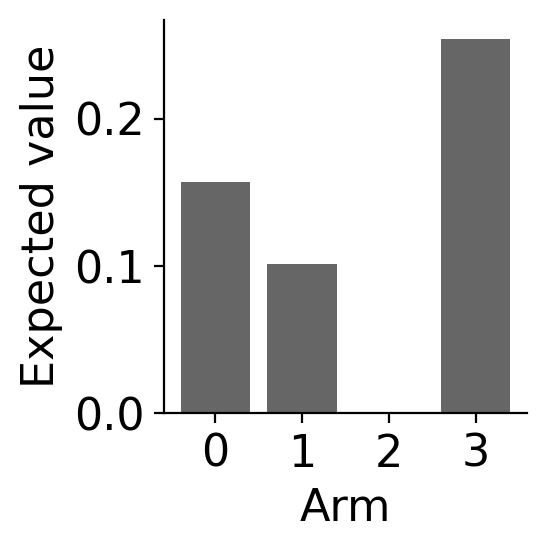

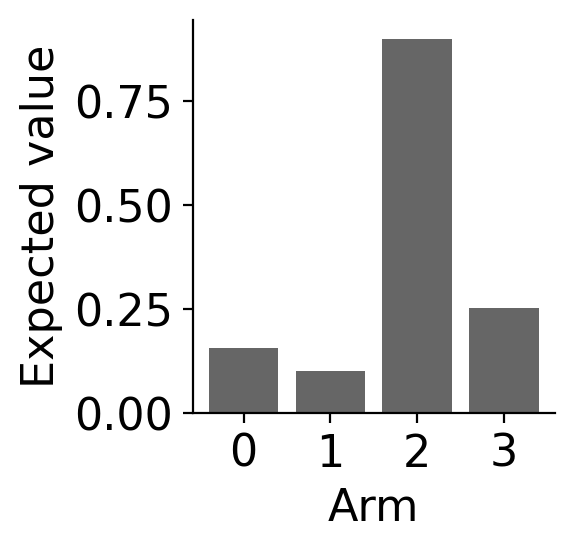

In [10]:
# Shared env params
seed = 5030

# plot env before
env1 = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.0)
env1.seed(seed)
plot_bandit(env1, alpha=0.6)

# plot env after
env2 = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.9)
env2.seed(seed)
plot_bandit(env2, alpha=0.6)

### Create this new changing bandit environment [3 pt]
To make the environment described above, set up a BanditChange4 environment with the following parameters:
- Have the number of trials before the change be 150.
- Have minimum and maximim probability of reward set to 0.1 and 0.3, respectively.
- Have the probability of reward for the "best" arm actually set to 0.0.
- Have the probability of reward for that arm after the change set to 0.9.
- Set the environment's seed to 5030.

In [11]:
# Your code here
num_experiments = 1
seed = 5030

env = BanditChange4(num_change = 150, p_min=0.1, p_max=0.3, p_best=0.0, p_change = 0.9)
env.seed(seed)

[5030]

### Question 2.1 [4 pt]
When testing later on, we will have each experiment last for 175 steps. What makes this a tricky problem? What would an agent have to do to succeed in this task?

In [ ]:
# Write your answer here, as a Python comment. Explain yourself.
# The experiment is tricky because in the last seventh of the experiment
#   the optimal in-period strategy changes so that the formerly worst strategy becomes the best.
# To succeed, the agent would have to continuously explore a sufficient ammount
#   throughout the first 150 periods so that it can detect this change when it happens.

### Creating the reinforcement learning agents [2 pt]

In the code cell below, fill in the code for creating each agent. Use the settings from the lab (repeated here for ease):
- Random agent: no settings needed
- Epsilon-greedy agent: use epsilon value of 0.1
- Upper confidence bound agent: use bonus weight of 0.5
- Softmax actor critic: use beta value of 7

In [12]:
ran = BanditActorCritic(
    # Fill in random agent code here
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

epy = BanditActorCritic(
    # Fill in epsilon greedy agent code here
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

ucb = BanditActorCritic(
    # Fill in upper confidence bound agent code here
    DeterministicActor(num_actions=env.num_arms),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0, bonus_weight = 0.5)
)

sft = BanditActorCritic(
    # Fill in softmax agent code here
    SoftmaxActor(num_actions=env.num_arms, beta=7),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)


agents = [ran, epy, ucb, sft]
names = ["random", "ep-greedy", "upper conf. bound", "softmax"]
colors = ["blue", "purple", "orange", "red"]

### Run the experiments [3 pt]

Fill in the code cell below to run 500 experiments for each agent, each with 175 steps. Set the seed to 5030 (have a code line for `seed=5030,` after the code line that sets the number of experiments).

In [20]:
# Your code here
num_steps = 175  # Number of choices each agent gets to make, (around 3 per arm)
num_experiments = 500
seed = 9030
# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        seed = seed,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/500 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/500 [00:00<?, ?it/s]

upper conf:   0%|          | 0/500 [00:00<?, ?it/s]

softmax:   0%|          | 0/500 [00:00<?, ?it/s]

### Visualize total rewards [3 pt]

In the code cell below, add code to plot the total reward for each agent type in the experiements.

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

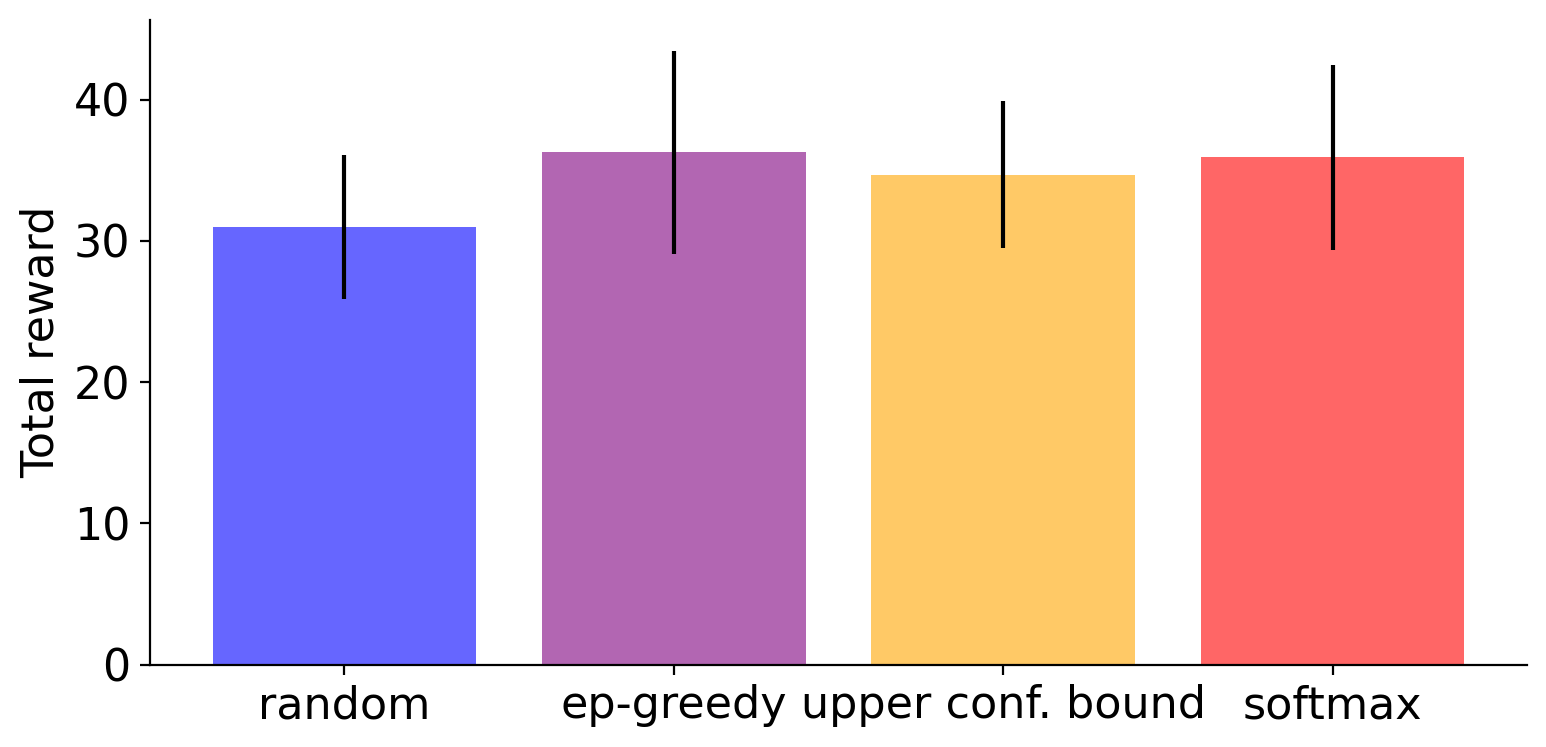

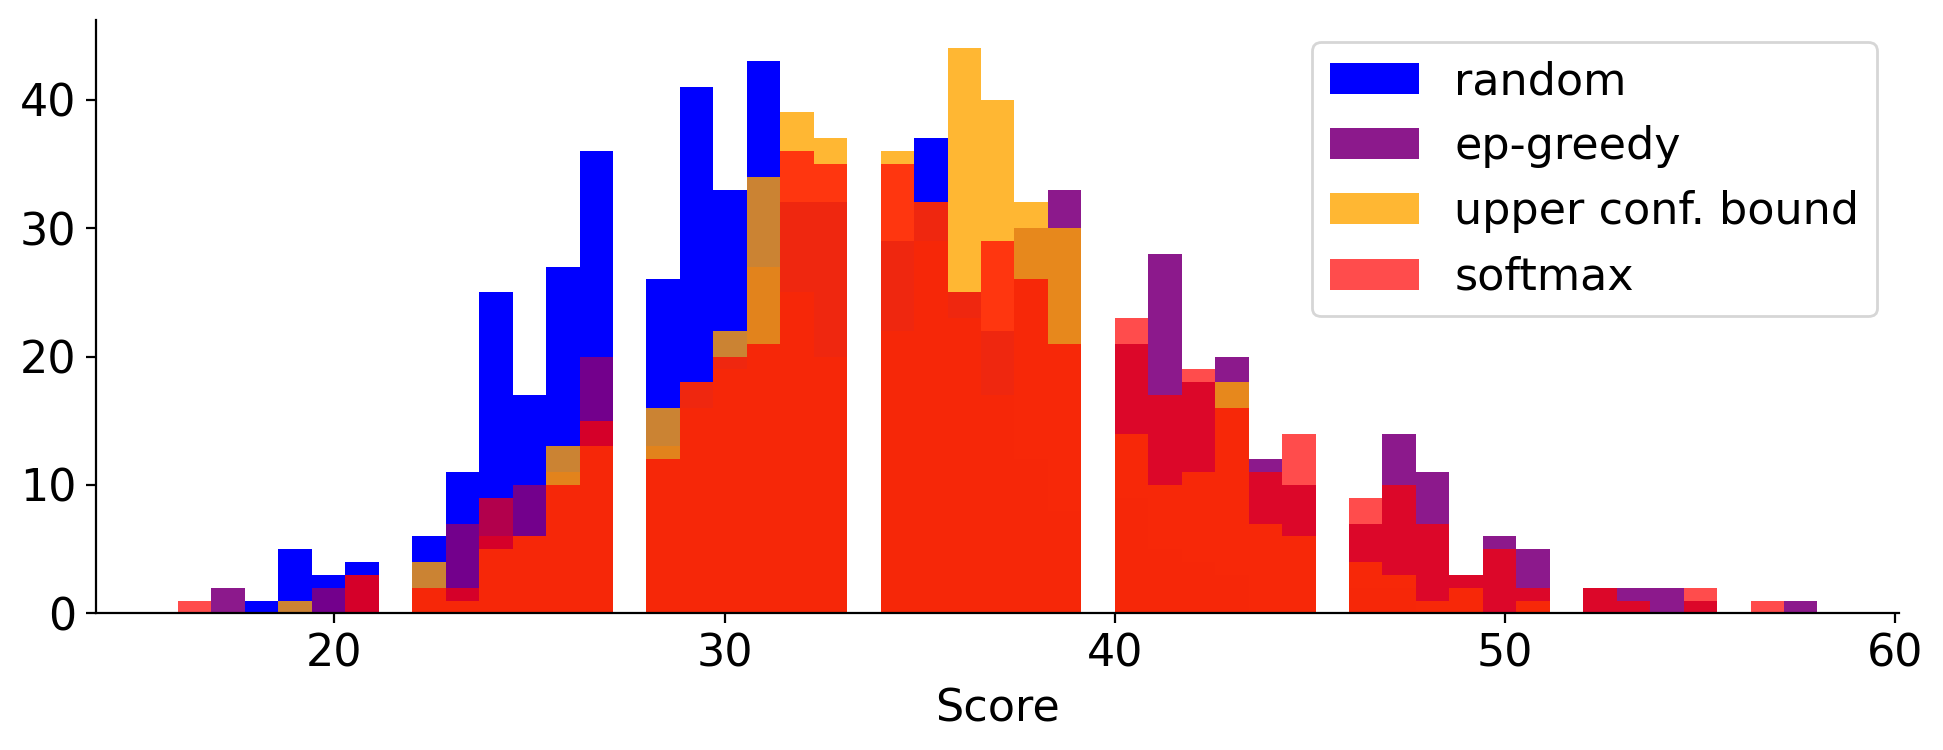

In [21]:
# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(8, 4))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
alphas = [1, 0.9, 0.8, 0.7]
fig = plt.figure(figsize=(10, 4))
count = 0
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=alphas[count], bins=np.linspace(np.min(scores), np.max(scores)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()
    count += 1

### Question 2.2 [4 pt]
How did each of the agents do, compared to one another? Why do you think this is the case?

In [ ]:
# Write your answer here, as a Python comment. Explain yourself.
# Consider that perfect play would recieve a reward of 0.25*150 + 0.9*25 = 60 in expectation
#   and maximally imperfect play 0*150 + 0.1*25 = 2.5 in expectation.
# We can see that the random agent receives a reward a bit below this range,
#   placing it roughly in the middle of the minimum and maximum expected reward.
# Random play will average 0.125 reward each period before period 151,
#   0.35 reward from 151 to 175, and ~0.157 overall.
# Thus, to do better than random an agent needs to get above 0.157 on average.
# The results suggest that all the other agents are able to do this on average.

# However, the epsilon-greedy agent often does worse than the random agent (it also sometimes does much better).
# This makes sense because it can get stuck pulling the 0.1 or 0.15 probability arms
#   which—in expectation—would both be not enough to clear the 0.157 reward per round.
# This happens because the epsilon-greedy algorithm only plays randomly 10% of the time,
#   which is an expected 15 random plays, 3.75 per arm,
#   for an expected 1.3125 hits from the 0.25 arm in the first 150 periods.
# This is not excactly true becuase if it gets the hit early on it may keep pulling the 0.25 arm,
#   but, if the epsilon-random agent gets a hit from the 0.1 or 0.15 arms first,
#   then the expected number of hits from the 0.25 arm in the first 150 periods is less than 1.3125.
# Furthermore,it is more likely than not to never get a hit from the 0.9 arm during the last 25 periods.
# In period 150, the agent cannot be stuck on arm 2 becuase it never gives a reward;
#   thus, the epsilon-greedy agent will get 0.5625 hits from the 0.9 arm in expectation.
# However, epsilon-greedy can get lucky and get a hit from the 0.25 arm immediately,
#   and then get a hit from the 0.9 arm soon after period 150,
#   after which it can subsequently pull 92.5% of the time.
# This allows the epsilon-greedy agent to have a wide range of performance,
#   giving it the highest variance performance distribution.

# The UCB agent does better than the random agent while seemingly not doing as well as the epsilon-greedy and softmax agents
#   and has less variance than the latter two agents.
# This is because the UCB agent explores more at first and then does so less over time.
# By using the upper confidence bound of an arm,
#   the UCB agent will sample all of the arms to some extent,
#   giving it some understanding of the true value of each arm,
#   and will tend to a more exploitative strategy after playing over time.
# This will often prevent the catastrophic failures that epsilon-greedy agents can experience
#   because the UCB agents will more reliably realize that the 0.25 arm is better than the others.
# However, because the UCB agent always explores in the beginning
#   (guaranteeing some suboptimal pulls of the 0.1 and 0.15 arms),
#   and doesn't explore as much later in the game
#   (making it unlikely to learn about the 0.9 arm),
#   it does not have as many radical successes.

# The softmax agent does about as good as the epsilon-greedy agent but has much less variance.
# This is because the softmax agent plays each strategy in proportion to their reward,
#   but with a beta of 7 will pull from more rewarding arms much more.
# This allows the agent to explore while still benefiting from the must rewarding arms it has experienced
#   proportional to how good the best thing it experiences is.
# Thus, after period 150, if the softmax agent samples the 0.9 arm enough times to know how good it is
#   it will be very unlikely to play anything else.
# And, because e^0 is 1, the softmax agent will always be capable of sampling the 0.9 arm
#   or any other arm if it has gotten unlucky,
#   making it unlikley for the agent to gett stuck pulling bad arm for the whole experiment.
# However, it is much less exploitative during the first 150 periods
#   because none of the arms are way way better than the others.
# If softmax learns the correct expected value of each arm in the first 150 periods,
#   it will play the 0.25 arm with roughly 50% probability
#   which is much less than epsilon-greedy's 92.5% if it did the same.

### Question 2.3 [4 pt]

Re-run just the experiments and reward plotting with the following random seeds: 6030, 7030, 8030, and 9030. Make sure you are just changing the seed for the experiments, not for the bandit task itself.

How consistent are the results you see? What does this tell you about the stability of the patterns you described in Question 2.2? Why do you think this is the case?

In [17]:
# Write your answer here, as a Python comment. Explain yourself.
# 6030
# Random has a much higher mean with similar variance than 5030.
# Epsilon-greedy's reward has a similar mean but much lower variance than 5030.
# UCB has a higher mean but similar variance than 5030.
# Softmax's reward mean and variance are similar to 5030.
# This makes epsilon-greed, softmax, and to a lesser extent UCB look indistinguishable.
# All distributions look fairly binomial (normal).

# 7030
# Every algorithm performed much worse than 5030.
# Relatively, UCB's performance decreased less and thus does the best.
# Variance patterns are typical (Var[Reward_{random}], Var[Reward_{UCB}] < Var[Reward_{ep-greedy}], Var[Reward_{softmax}])
#   except that softmax's variance is larger relative to epsilon-greedy's than is typical.
# Distributionally, Random, UCB, and Softmax look quite binomial (normal)
#   while ep-greedy looks more right skewed than typical.

# 8030
# Loks similar to 6030, i.e., epsilon-greedy, UCB, and softmax perform similarly on average
#   with random a bit lower, except every agent's average reward is lower than 6030
#   (random does worse relatively and UCB as well but by a smaller margin).
# Epsilon-greedy's variance is considerably higher than in 6030,
#   making it more on par with 5030.
# All distributions look fairly binomial (normal).

# 9030
# Loks similar to 6030, i.e., epsilon-greedy, UCB, and softmax perform similarly on average
#   with random a bit lower, except every agent's average reward is *slightly* lower than 6030.
# The only difference is that epsilon-greedy has higher variance than it does in 6030,
#   though not as much as 8030.
# All distributions look fairly binomial (normal).

# The patterns I observed in 2.2 seem broadly true:
#   1) Epsilon-greedy and softmax tend to perform similarly and slightly better than UCB
#   2) Random does the worst by a larger margin than any of the others do against each other
#   3) Random and UCB have lower variance than epsilon-greedy and softmax
#   4) Epsilon-greedy has more variance than Softmax
# This makes sense as there is a lot of path dependence in the performance of the models (other than random).
# Thus, a lot of trials need to be done to get accurate results.

---
## Part 3 - Exploration agents in information-distorted environments [26 pt]

In the last part of lab 8 we saw how the distortion in the channel driven by *missing information* influenced the efficiency of our Info agent. In this second part of the homework, you will investigate the effect of distortion driven by *sensor noise*.

Here we will test a range of *noise_sigma* (as opposed to *p_scent*) values. Essentially we will be turning *up* the distortion as *noise_sigma* increases. For these experiments we will hold the *p_scent* constant at 0.1 (a sparse information environment).

### Coding

In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 8 for help.

#### Install relevant code libraries.

In [ ]:
# Your code here
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git


  Cloning https://github.com/parenthetical-e/explorationlib to /tmp/pip-req-build-ssaqsiq8
  Running command git clone --filter=blob:none --quiet https://github.com/parenthetical-e/explorationlib /tmp/pip-req-build-ssaqsiq8
  Resolved https://github.com/parenthetical-e/explorationlib to commit 51e93ea9a3866d32202fb912bc46f7fcb18e8a17
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=41444 sha256=907b7c979f28888da398d3f0a15271c4db169e61fcdccabe7cfeb450a90d192b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nis7eywm/wheels/d9/d4/9d/27de3c1116f2d61555f595f2d2f5e4bad227a58ce9999d2438
Successfully built explorationlib


  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-oh0yd0vo
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-oh0yd0vo
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Preparing metadata (setup.py) ... done


#### Import relevant modules.

In [22]:
# Your code here
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import WSLSGrid
from explorationlib.agent import CriticGrid
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid
from explorationlib.agent import ActorCriticGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

#### Add code for setting up pretty plots.

In [23]:
# Your code here
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Code for running your experiments

We've provided some code below with *p_scent* set at the sparse-information value of 0.1. We also provide a range of *noise_sigma* that you will use. The range is on an exponential scale, just because it makes sense given that *noise_sigma* can only be 0 or greater.

In [24]:
# Our parameters
p_scent = 0.1
noise_sigmas = [0.5625, 0.75, 1, 1.33, 1.77] # range of values on an exp. scale

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = noise_sigmas # list(range(5))

#### Complete the code below and run your experiments. We've specified the default parameters for the agent and environment below. Fill in the code for running experiments at each *noise_sigma* value within the loop below. (Add your code where it says `# ADD YOUR EXPERIMENT CODE HERE - BE SURE TO CHECK INDENTATION`.) [5 pt]

In [25]:
# Define the accumulation parameters
drift_rate = 1.0
threshold = 3
accumulate_sigma = 1.0

# Shared
num_experiments = 100
num_steps = 400
seed_value = 5838

# Define non-scent probability values
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# How many experiments to run
num_experiments = 100

# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)

# Run
results = []

for i, noise_sigma in zip(names, noise_sigmas):
  # ADD YOUR EXPERIMENT CODE HERE - BE SURE TO CHECK INDENTATION
    # Targets
  prng = np.random.RandomState(seed_value)
  targets = uniform_targets(num_targets, target_boundary, prng=prng)
  values = constant_values(targets, 1)

  # Scents
  scents = []
  for _ in range(len(targets)):
      coord, scent = create_grid_scent_patches(
          target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
      scents.append(scent)

  # Env
  env = ScentGrid(mode=None)
  env.seed(seed_value)
  env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

  exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )

  results.append(exp)

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

#### Add in code below to plot the bumber of deaths for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [3 pt]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

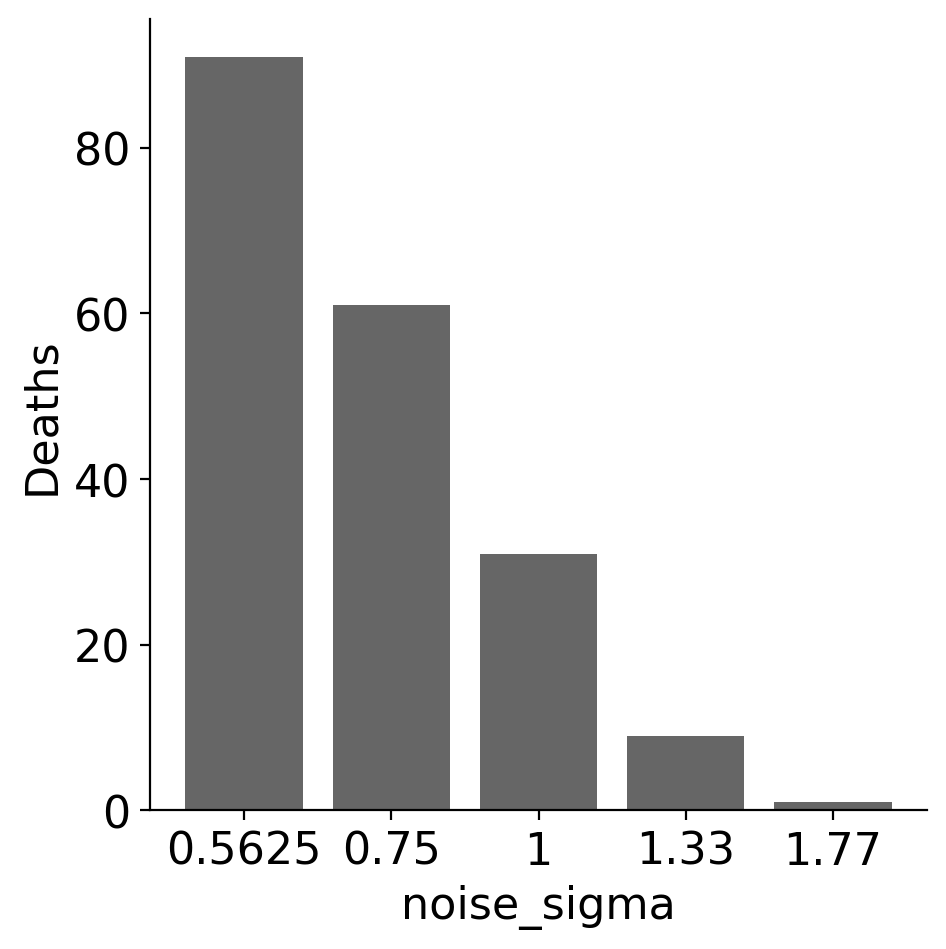

In [26]:
# Your code here
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

#### Add in code below to plot max score for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [3 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

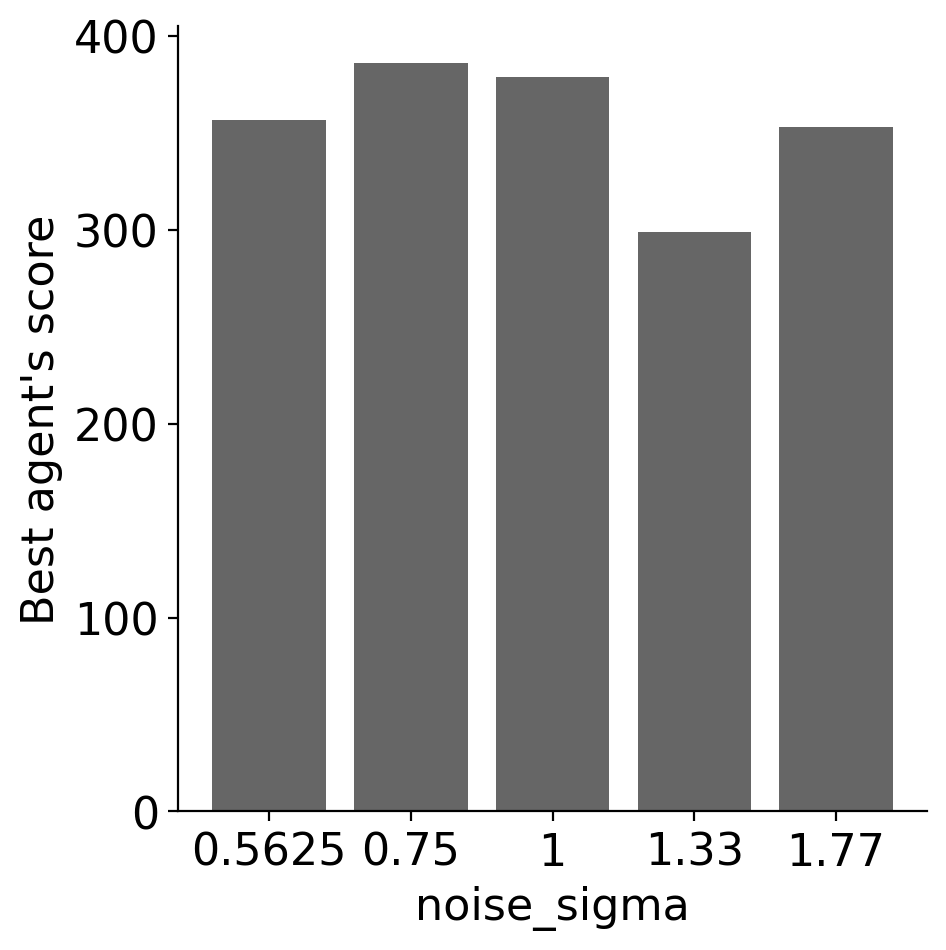

In [27]:
# Your code here
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

#### Add in code below to plot average score and score frequency distributions for different values of *noise_sigma*. Make sure your x-axes are labeled with noise_sigma, not p_scent. [3 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

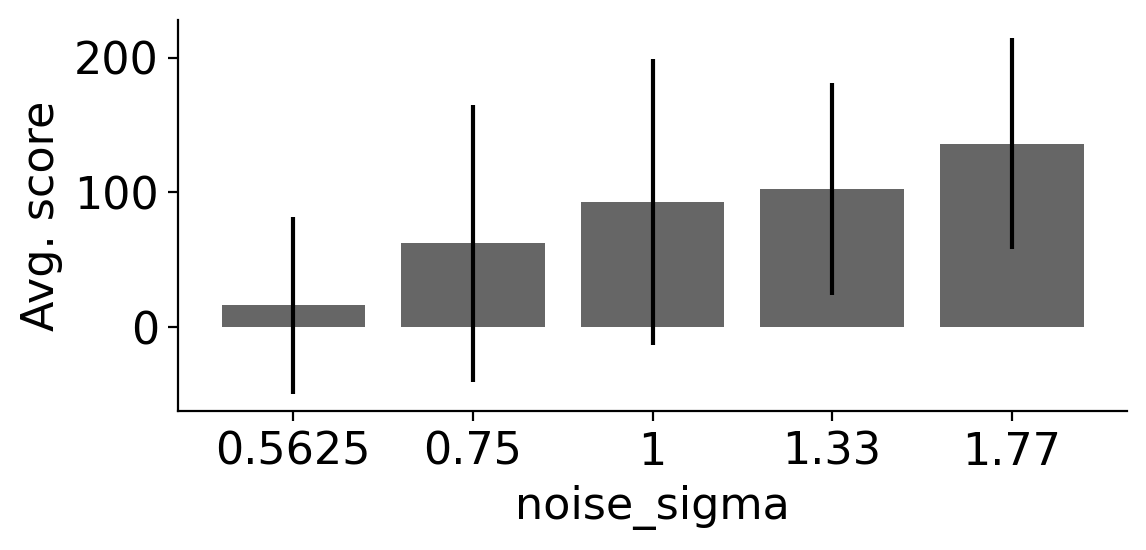

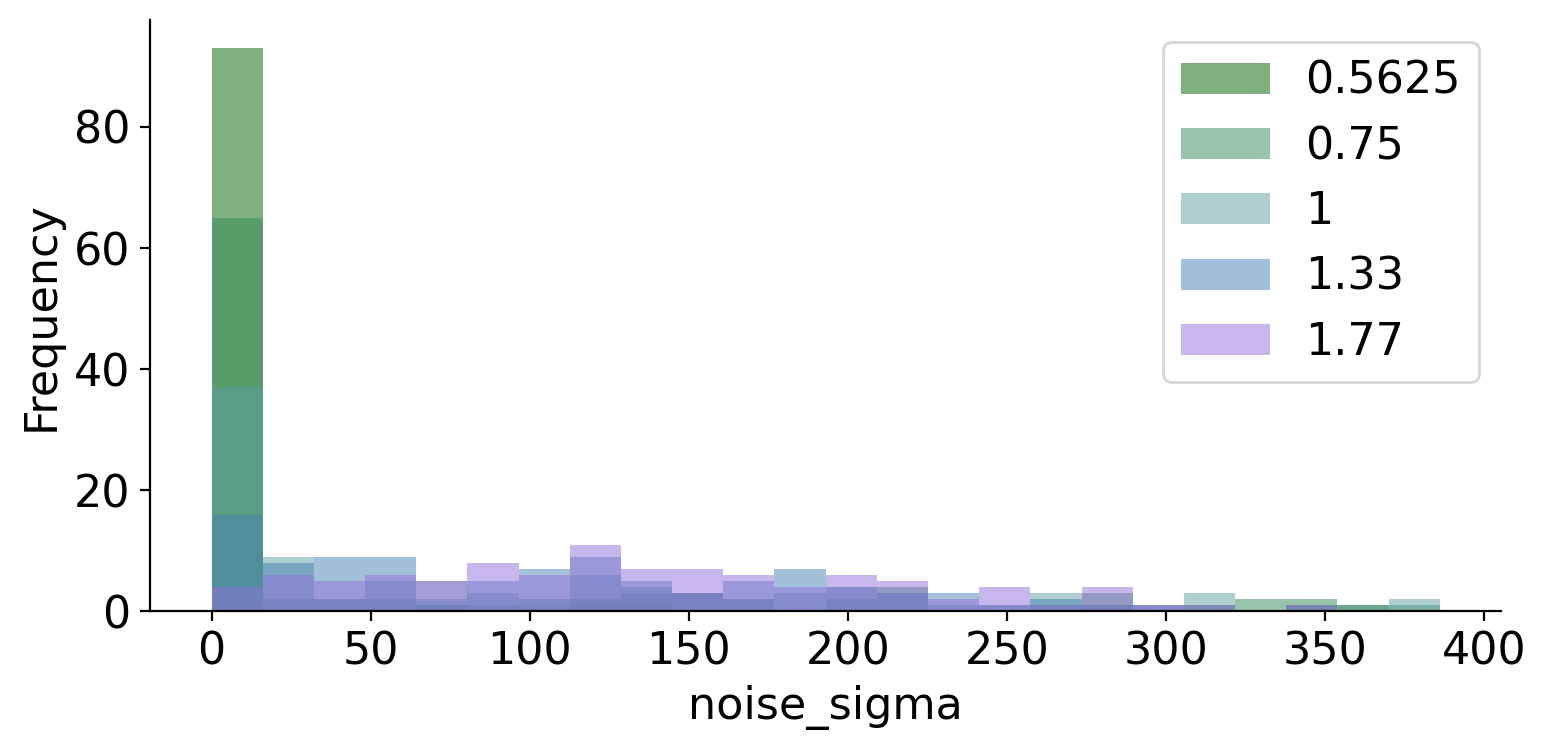

In [28]:
# Your code here
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(8, 4))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins = np.linspace(0, np.max(scores), 25))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("noise_sigma")
    plt.tight_layout()
    sns.despine()

### Question 3.1 [4 pt]

How does increasing *noise_sigma* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

In [ ]:
# Write your answer here, as a python comment
# Consider that noise sigma denotes the standard deviation of the noise,
#   thus higher noise sigma increases the average difference from baseline of scent values.
# Increasing the noise increases the agent's score and decreases the score's variance
#   (initially it decreases variance because too many agents are getting 0).
# Particularly, lower average noise magnitudes result in many catastrophic failures
#   and a few more high performing outliers (not for the minumum value which jsut does poorly).
# This is because infotaxis works best in high entropy environments
#   since higher entropy allows greater information to be conveyed
#   in addition to meaning there is greater uncertainty.
# When the signal is too clear, there isn't enough signal decay to produce a gradient sufficiently close to the source.
# So, when the entropy is too low, infotaxis agents can get caught in unproductive circuitous routes,
#   leading to catastrophic failures where not a single point is scored.

### Question 3.2 [4 pt]

Re-run the simulations from this section, but now change the drift-rate from 1.0 to 0.75. How and why does this influence the agent's behavior (compared to the higher drift-rate)?

In [ ]:
# Write your answer here, as a python comment
# The lower two noise sigma values get zero score in every trial, otherwise increasing the noise's variance increases the average score.
# The variance of scores are increased.
# By lowering the drift rate, it takes a larger magnitude of noise to influence the decision since noise has a zero average over time it only
#   acts directionally for some local duration.
# Thus, the lower the drift rate decreases the noise's ability to act on the agent, effectively decreasing it in some sense.

### Question 3.3 [4 pt]

Now set the drift-rate back to 1.0 and reduce the boundary height from 3.0 to 1.5. Re-run the simulations in again. How and why does this influence the agent's behavior (compared to the higher boundary height)?

In [ ]:
# Write your answer here, as a python comment
# The average score is not affected by the variance of the noise, but the variance of the scores decreases as the variance of the noise increases.
# By lowering the boundary height, a smaller magnitude of noise goes further in affecting the decision for the same reasons as described in 3.2 but reversed.
# A lower boundary height increases the importance of a single period, which allows noise to matter (since it is mean zero as time approaches infinity).
# Thus, I suspect that with the decreased boundary height, the lowest noise sigmas are still sufficient for creating the high entropy environment
#   relative the sensitivity of the agent.
# So, changing the noise sigma does not effect the average performance as meaningfully.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> None

**DUE:** 5pm ET, Nov. 27th, 2023. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.